In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import activations

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
# for 2nd attempt
from keras.callbacks import EarlyStopping

import keras.backend as K

Using TensorFlow backend.


# Fitting a 1d function with a deep neural network

## Aim

To find the the best architecture and training setup to fit a pre-defined function

$f(x) = 10\sin(10 x) + (x-1)(x+2)(x-1/2)+80 e^{-10*(x-2)^2} $

In [2]:
# let's choose a simple 1->1 function to train
def f(x):
    return 10*np.sin(10*x)+(x-3)*(x+2)*(x-1/2)+80*np.exp(-(x-2)**2/0.1)

In [3]:
# evaluate some data points
datasize = 500
datapoints = np.linspace(-5,5,datasize)
datavalues = f(datapoints)
data = np.transpose([datapoints,datavalues])

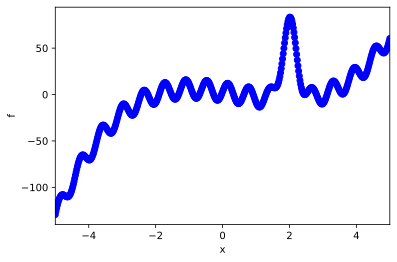

In [4]:
# plot the data points to see how they are distributed
plt.plot(datapoints, datavalues, 'bo')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

In [5]:
## split into testing and training sets
split = int(len(data)*80/100)

The output range is not between 0 and 1 so if we were to use a tanh/sigmoid activation function it would fail. We can process the output data using

$\hat{f}_i = \frac{f_i-f_{\rm min}}{f_{\rm max}-f_{min}}$

which lies between 0 and 1

In [6]:
# make sure all data is positive
def process_data(data):
    data_in_array = data[:,0]
    #data_in_ave = np.ave(data_in_array)
    #data_in_max = np.max(data_in_array)
    #data_in_min = np.min(data_in_array)
    #data_in_std = np.std(data_in_array)
    
    data_out_array = data[:,1]
    #data_out_ave = np.ave(data_out_array)
    data_out_max = np.max(data_out_array)
    data_out_min = np.min(data_out_array)
    #data_out_std = np.std(data_out_array)
    
    data_out_array = (data_out_array-data_out_min)/(data_out_max-data_out_min)
    
    data_processed = np.transpose([data_in_array,data_out_array])
    return data_processed, data_out_min, data_out_max

def unprocess_prediction(values, ymin, ymax):
    return values*(ymax-ymin) + ymin

In [7]:
tf.keras.backend.clear_session()

In [8]:
# Initialise model: 1-16-32-16-1
model = Sequential([
    Dense(16, activation='sigmoid', input_shape=(1,)),
    Dense(32, activation='sigmoid'),
    Dense(16, activation='sigmoid'),
    Dense(1)
])

# Compile model
model.compile(
    optimizer = Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss = 'mean_squared_error')

In [9]:
data_processed, ymin, ymax = process_data(data)
print(ymin, ymax)

-129.3762514629607 83.46098428524975


[  -5.         -129.37625146]
[-5.  0.]


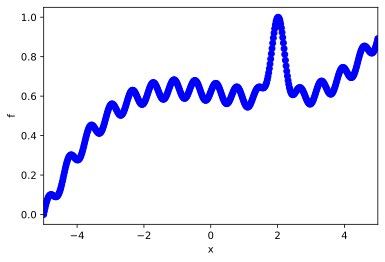

In [10]:
print(data[0])
print(data_processed[0])

plt.plot(data_processed[:,0], data_processed[:,1], 'bo')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

In [11]:
ES = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=1000,
    verbose=0,
    restore_best_weights=True)

history = model.fit(
    data_processed[0:split,0],
    data_processed[0:split,1],
    epochs=200,
    validation_data=(data_processed[split:,0], data_processed[split:,1]),
    #callbacks=[ES],
    #batch_size=512,
    verbose=0
)

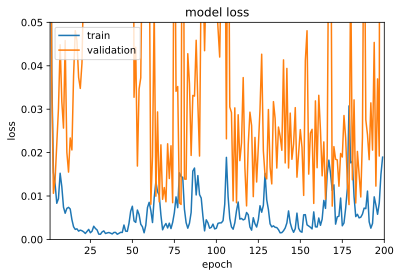

In [12]:
# now we can plot the history to see how the loss function for the
# training and validation set changed with epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xlim([1,200])
plt.ylim([0,0.05])
plt.show()

In [13]:
datapoints2 = np.random.uniform(low=-5, high=5, size=(1000,))
datavalues2 = np.array(list(map(f, datapoints2)))
valuespred = model.predict(datapoints2)

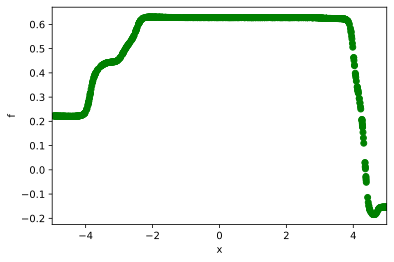

In [14]:
plt.plot(datapoints2, valuespred, 'go')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

In [15]:
valuespred_un = unprocess_prediction(valuespred, ymin, ymax)

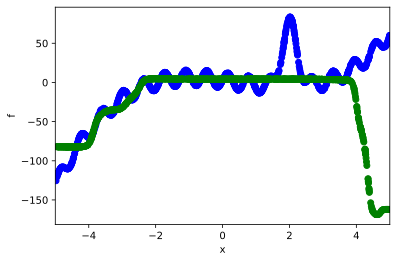

In [16]:
plt.plot(datapoints2, datavalues2, 'bo')
plt.plot(datapoints2, valuespred_un, 'go')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

## Exercises ##

1) Edit the code to create an arbitrary archictecture from a list of layer depths. How does the fit depend on the architecture?

2) Change the activation function used in the nodes to tanh, what changes in the output? Do you need to change the normalisation?

3) Vary the number of input data points. Is there an optimal number?

4) Using the template for early stopping try to optimise the number of epochs needed by the network

https://keras.io/api/callbacks/early_stopping/

5) How does batch size affect the training time and fit?

6) Split the input and output data set according to random shuffle rather than a slice, do you see any affect? (see sklearn.model_selection.train_test_split).

7) Can we change the loss function to prefer certain regions or features? (Only think about this - no need to implement it)